In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime


In [38]:
%%time
df = pd.read_csv("data/HDeviceCGM.txt", sep="|")
print(df.shape)
df.head()


(14950661, 10)
CPU times: user 13.1 s, sys: 2.17 s, total: 15.3 s
Wall time: 15.3 s


,RecID,ParentHDeviceUploadsID,PtID,SiteID,DeviceDtTmDaysFromEnroll,DeviceTm,DexInternalDtTmDaysFromEnroll,DexInternalTm,RecordType,GlucoseValue
0,1655236,782,183,12,-6,05:35:41,-6.0,12:37:02,CGM,162.0
1,1655237,782,183,12,-6,05:30:41,-6.0,12:32:02,CGM,164.0
2,1655238,782,183,12,-6,05:25:41,-6.0,12:27:02,CGM,168.0
3,1655239,782,183,12,-6,05:20:41,-6.0,12:22:02,CGM,169.0
4,1655240,782,183,12,-6,05:15:41,-6.0,12:17:02,CGM,170.0


In [39]:
%%time
pd.DataFrame({col:len(df[col].unique())for col in df.columns}, index=["unique"]).T


CPU times: user 5.15 s, sys: 272 ms, total: 5.42 s
Wall time: 5.42 s


,unique
RecID,14950661
ParentHDeviceUploadsID,3772
PtID,226
SiteID,14
DeviceDtTmDaysFromEnroll,561
DeviceTm,86400
DexInternalDtTmDaysFromEnroll,1000
DexInternalTm,86401
RecordType,2
GlucoseValue,491


In [40]:
df.RecordType.value_counts()

CGM            14807435
Calibration      143226
Name: RecordType, dtype: int64

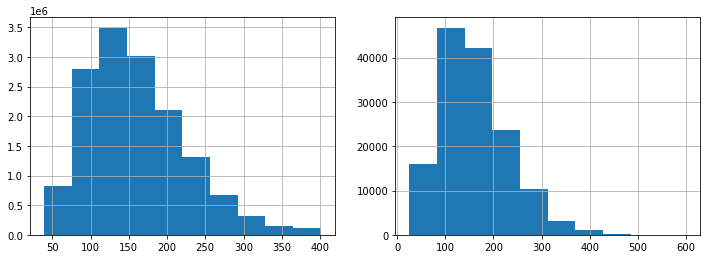

In [41]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
df[df.RecordType=="CGM"].GlucoseValue.hist(ax=axs[0])
df[df.RecordType!="CGM"].GlucoseValue.hist(ax=axs[1])
plt.show()


In [42]:
df = df[df.RecordType=="CGM"]

(3771, 1)


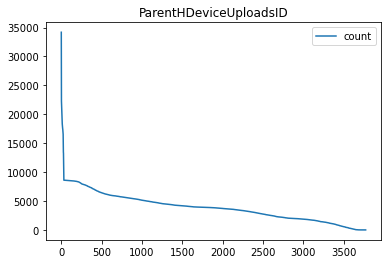

In [43]:
col = "ParentHDeviceUploadsID"
tmp = df[["RecID",col]].iloc[:].groupby(col).count().rename(columns = lambda x: "count").sort_values("count", ascending=False)
print(tmp.shape)
tmp.reset_index(drop=True).plot()
plt.title(col)
plt.show()
#tmp

(226, 1)


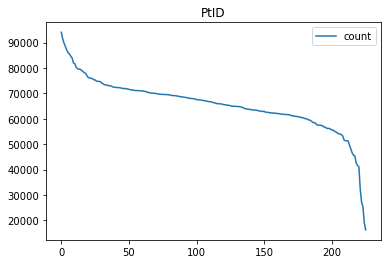

In [44]:
col = "PtID"
tmp = df[["RecID",col]].iloc[:].groupby(col).count().rename(columns = lambda x: "count").sort_values("count", ascending=False)
print(tmp.shape)
tmp.reset_index(drop=True).plot()
plt.title(col)
plt.show()
#tmp

(14, 1)


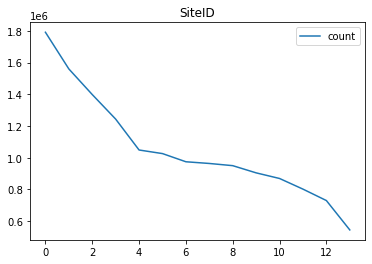

In [45]:
col = "SiteID"
tmp = df[["RecID",col]].iloc[:].groupby(col).count().rename(columns = lambda x: "count").sort_values("count", ascending=False)
print(tmp.shape)
tmp.reset_index(drop=True).plot()
plt.title(col)
plt.show()
#tmp


In [46]:
PtIDs = df.PtID.value_counts()
PtIDs

263    94089
77     91653
193    89850
277    88479
229    87138
       ...  
39     32316
52     27161
266    25383
223    19065
289    16274
Name: PtID, Length: 226, dtype: int64

In [47]:
%%time
basedate = pd.to_datetime("2021-01-01")
ts = df[df.PtID==PtIDs.keys()[1]].copy()
ts["date"] = ts["DeviceDtTmDaysFromEnroll"].apply(lambda d: basedate + pd.DateOffset(d))
ts["date"] = ts["date"].apply(lambda d: str(d).split()[0])
ts["ts"] = pd.to_datetime(ts["date"] + " " + ts.DeviceTm)
ts = ts.set_index("ts").sort_index()#.dropna()


CPU times: user 1.6 s, sys: 7.83 ms, total: 1.61 s
Wall time: 1.56 s


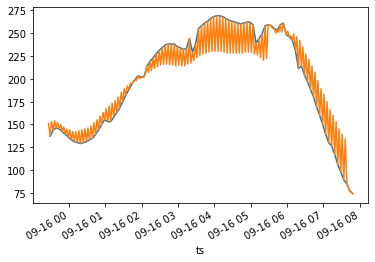

In [48]:
last = 200
ts.iloc[-last:].dropna()["GlucoseValue"].plot()
ts.iloc[-last:]["GlucoseValue"].plot()
plt.show()


In [49]:
ts.PtID.unique(), ts.SiteID.unique()


(array([77]), array([11]))

In [91]:
n_sample = 24*12
tst = ts.dropna()["GlucoseValue"].head(n_sample*2)
oidx = tst.index
nidx = pd.date_range(oidx.min(), oidx.max(), freq='300s')
res = tst.reindex(oidx.union(nidx)).interpolate('index').reindex(nidx).head(n_sample)
#res.plot(style='.-')
#tst.plot(style=':')
#plt.show()
res.to_csv("ewma_GVI/data/CGM_p%d_24h.csv"%ts.PtID.unique()[0], header=None)


170.66666666666666

<AxesSubplot:>

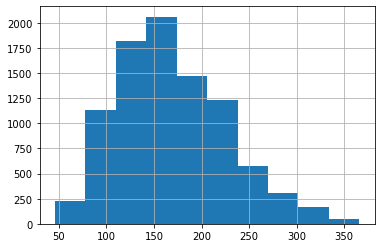

In [72]:
res.hist()

In [69]:
ts = ts.dropna()


count    70219.000000
mean       166.068528
std         57.290580
min         39.000000
25%        124.000000
50%        159.000000
75%        202.000000
max        401.000000
Name: GlucoseValue, dtype: float64

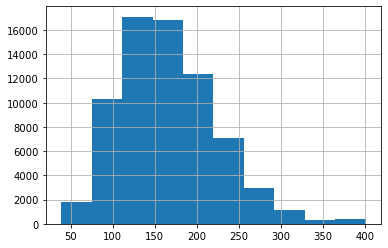

In [70]:
ts["GlucoseValue"].hist()
plt.plot()

ts["GlucoseValue"].describe()


In [16]:
halflife = "7 days"
ts["EWMA"] = ts["GlucoseValue"].ewm(halflife=halflife, times = ts.index).mean()


In [17]:
ts["IR"] = 100*(ts["GlucoseValue"] >= 70.)*(ts["GlucoseValue"] <= 180.)
ts["PTIR"] = ts["IR"].ewm(halflife=halflife, times = ts.index).mean()


In [18]:
plotcols = ["GlucoseValue","EWMA", "IR", "PTIR"]


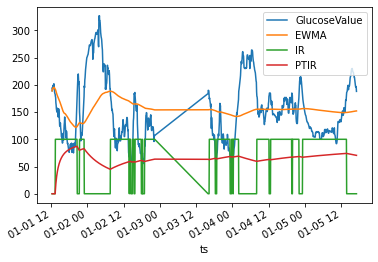

In [19]:
ts.iloc[:1000][plotcols].plot()
plt.show()


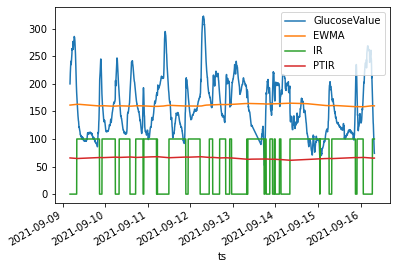

In [20]:
ts.iloc[-2000:][plotcols].plot()
plt.show()


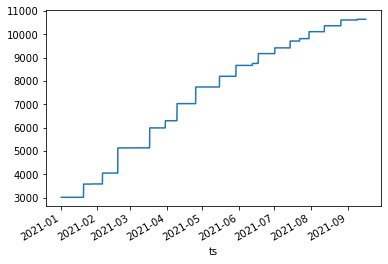

In [21]:
ts.iloc[:]["ParentHDeviceUploadsID"].plot()
plt.show()


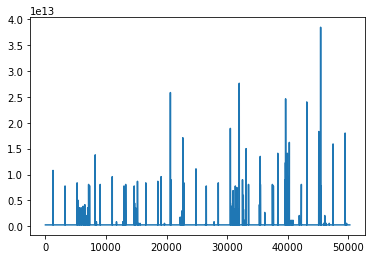

In [22]:
plt.plot(np.int64(np.diff(ts.index))[20000:])
plt.show()


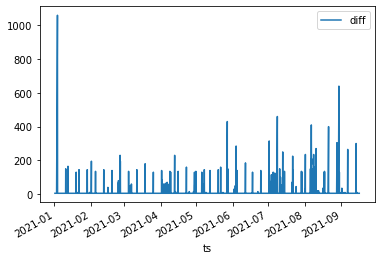

In [23]:
ts["diff"] = (ts.reset_index()["ts"].diff().dt.total_seconds()/60.).values
ts[["diff"]].plot()
plt.show()


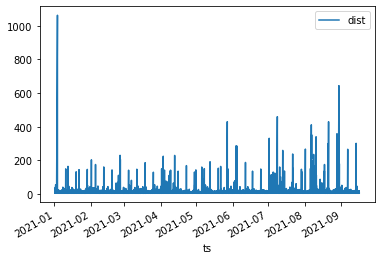

In [24]:
ts["dist"] = (ts["GlucoseValue"].diff()**2 + ts["diff"]**2)**0.5
ts[["dist"]].plot()
#ts["dist"].ewm(halflife=halflife, times = ts.index).mean().plot()
plt.show()


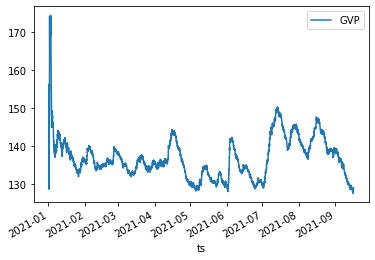

In [25]:
ts["GVP"] = 100. * ts["dist"].ewm(halflife=halflife, times = ts.index).mean() \
          / ts["diff"].abs().ewm(halflife=halflife, times = ts.index).mean() - 1
ts[["GVP"]].plot()
plt.show()


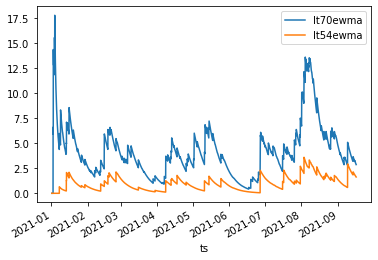

In [26]:
ts["lt70"] = 1.*(ts["GlucoseValue"] < 70.)
ts["lt54"] = 1.*(ts["GlucoseValue"] < 54.)
ts["lt70ewma"] = 250.*ts["lt70"].ewm(halflife=halflife, times = ts.index).mean()
ts["lt54ewma"] = 400.*ts["lt54"].ewm(halflife=halflife, times = ts.index).mean()
ts[["lt70ewma","lt54ewma"]].plot()
plt.show()

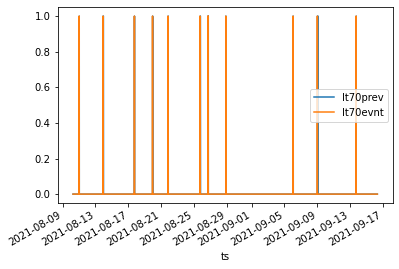

In [27]:
ts["lt70prev"] = 1.0*(ts["lt70"].rolling(4).sum() == 4)
ts["lt70evnt"] = 1.0*(ts["lt70prev"].iloc[::-1].rolling(2).sum() == 1).iloc[::-1] \
               * 1.0*(ts["lt70prev"].rolling(2).sum() == 0)
ts[["lt70prev","lt70evnt"]].iloc[-10000:].plot()
plt.show()


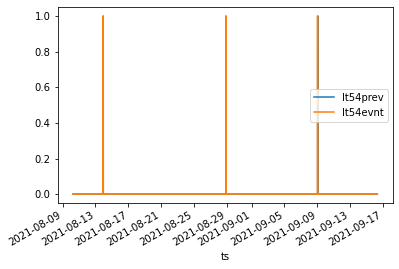

In [28]:
ts["lt54prev"] = 1.0*(ts["lt54"].rolling(4).sum() == 4)
ts["lt54evnt"] = 1.0*(ts["lt54prev"].iloc[::-1].rolling(2).sum() == 1).iloc[::-1] \
               * 1.0*(ts["lt54prev"].rolling(2).sum() == 0)
ts[["lt54prev","lt54evnt"]].iloc[-10000:].plot()
plt.show()


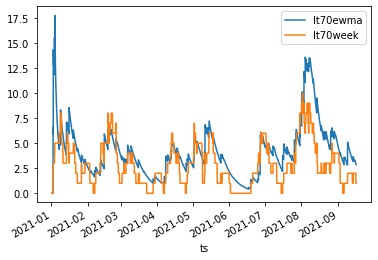

In [29]:
ts["lt70week"] = ts["lt70evnt"].rolling("7D").sum()
ts[["lt70ewma","lt70week"]].plot()
plt.show()


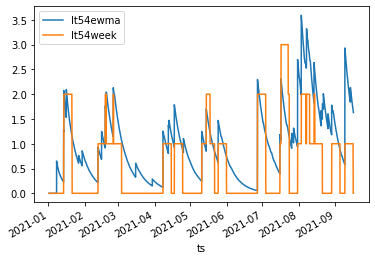

In [30]:
ts["lt54week"] = ts["lt54evnt"].rolling("7D").sum()
ts[["lt54ewma","lt54week"]].plot()
plt.show()


In [31]:
def f_H54(x):
     return 0.5 + 4.5*(1-np.exp(-0.81093*x))
    
#plt.plot(f_H54(np.linspace(0,10,10)))
    
def f_H70(x):
    c = 1.0*(x <= 7.65)
    return c*(0.625 + 0.5714*x) + (1-c)*5.0
    #if x <= 7.65:
    #    return 0.625 + 0.5714*x
    #else:
    #    return 5.0

#plt.plot(f_H70(np.linspace(0,10,10)))
    
def f_GVP(x):
    return 1. + 9/(1.+np.exp(-0.049*(x-65.47)))

#plt.plot(f_GVP(np.linspace(0,200,200)))

def f_PTIR(x):
    return 1. + 9/(1.+np.exp(0.0833*(x-55.05)))

#plt.plot(f_PTIR(np.linspace(0,100,100)))

def f_MG(x):
    return 1. + 9/(1.+np.exp(0.1139*(x-72.08))) + 9/(1.+np.exp(-0.09195*(x-157.57)))

#plt.plot(f_MG(np.linspace(0,400,400)))


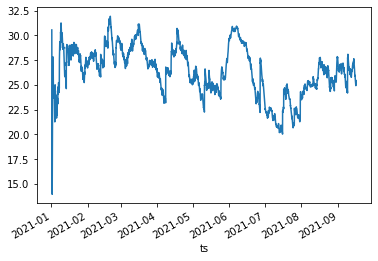

In [32]:
ts["PGS"] = f_H54(ts["lt54ewma"]) + f_H70(ts["lt70ewma"]) + f_GVP(ts["GVP"]) \
          + f_PTIR(ts["PTIR"]) + f_MG(ts["EWMA"])

ts["PGS"].plot()
plt.show()
